# Introduction

We often hear the phrase, "correlation does not imply causation." The thought is that just because two variables are correlated with each other, doesn't mean that one causes the other. This point is easy to illustrate with silly example.

![](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/correlation_does_not_imply_causation.png)

Perhaps Nicholas Cage should think twice before agreeing to be in Pig 2. 

For the last 100 years or so, it has been common wisdom that statistical information cannot answer causal information. All we see are the correlations. We don't see the causal relationships in the data. Motivated by examples like the graph above, scientists have put really high standards on when and whether we can infer causal relationship. 

But if you take this common wisdom too seriously, it leads you toward other really silly conclusions. I have two in mind. One is is about the writing style in science. The other is about philosophy. Loads of scientific papers are filled with convoluted language to avoid ever asserting that something causes something else. A psychiatric paper studying the effectiveness of an anti-depressant might say that the drug is "associated" with a decrease in the severity of depression. Or they might say the data "suggests" effectiveness. Or, that the drug is "linked" with bad side effects. All of these terms are ambiguous between correlation and causation. They play this little linguistic dance because it's really causation that we care about. No one wants a drug that is correlated but does not actually cause improvements in mental wellbeing. We want causes. But statistics tells us to be quiet and stick to correlations.

Here's the philosophy connection. Let's assume that correlation doesn't imply causation. How then could we ever learn about what causes what? All we ever see in life are the correlations. We don't literally see the causation happening. Causation is some invisible theoretical process. Science is suppose to be objective, about the data that we can all see and agree upon. But sometimes causal situations look identical to non-causal situations when you only look at the data. If Nic Cage filmed caused swimming pool accidents, the data would look just like it does above. David Hume, the guy who gave us the problem of induction, also pointed out the puzzle about how we ever learn about causation from observation. So we are left with a big question, if correlation doesn't imply causation, what does?

To explore these themes, we are going to uses some modeling tools. The main new topic is something called causal graph theory. If you want to know how much a drug improves mental wellbeing, you need a causal graph + a properly specified statistical model. Causal graph theory gives you the tools to design any kind of causal system you want. It also comes with a set of rules for clarifying exactly what we would have to measure and include in a statistical model to correctly estimate the effects we are after.

# Rethinking of our models as regressions

Causal graph theory lets us re-express our statistical models as a network of linear functions. While these networks can get very complex, each linear function is very simple. Before we can appreciate how these networks work, we need to appreciate that all the models we have built so far can be reexpressed as linear functions. This linear function approach is just a way of redescribing models you are already familiar with. 

Let me illustrate by redoing an analysis we did on the Bargh walking speed experiment. Here's the packages.

In [7]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import ipywidgets as widgets
from scipy import stats
from graphviz import Digraph

and the data.

In [5]:
url = 'https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_experiment_2_data'

data = pd.read_csv(url)
control = data[data.group == 1]
primed = data[data.group == 0]
control_speed = control.speeds.values
primed_speed = primed.speeds.values
data

,group,speeds
0,0.0,9.610
1,0.0,7.110
2,0.0,7.880
3,0.0,7.380
4,0.0,7.050
5,0.0,8.510
6,0.0,8.260
7,0.0,8.680
8,0.0,7.860
9,0.0,9.020


So far, when we want to compare two groups, we just estimate the parameters of one group, then estimate the parameters of the other group and compare the estimates. So we might want to know the mean walking speed of one group and then learn the mean walking speed of the other group. Here's a simple gadget to remind yourself how that process works. Try to figure out which combination of parameters fit the data best.

In [3]:
def draw_two_normals(m1,m2,s1,s2):
    
    x = np.linspace(2,14,200)
    y1 = stats.norm(m1,s2).pdf(x)
    y2 = stats.norm(m2,s2).pdf(x)
    y1 = y1 / sum(y1)
    y2 = y2 / sum(y2)
    
    l1 = stats.norm(m1,s1).logpdf(control_speed)
    l2 = stats.norm(m2,s2).logpdf(primed_speed)
    
    likelihood = np.sum(l1 + l2)
    print("log likelihood: " + str(likelihood))

    plt.plot(control_speed,[0] * len(control_speed),'o',color="tab:blue",alpha=0.6)
    plt.plot(primed_speed,[0] * len(primed_speed),'o',color="tab:orange",alpha=0.6)
    plt.plot(x,y1,color="tab:blue",label="control group")
    plt.plot(x,y2,color="tab:orange",label="primed group")
    plt.legend()
    
widgets.interact_manual(draw_two_normals, 
         m1=widgets.FloatSlider(min=0, max=20, step=0.01, value=10),
         m2=widgets.FloatSlider(min=0, max=20, step=0.01, value=10),
         s1=widgets.FloatSlider(min=0.001, max=5, step=.01, value=1),
         s2=widgets.FloatSlider(min=0.001, max=5, step=.01, value=1));

interactive(children=(FloatSlider(value=10.0, description='m1', max=20.0, step=0.01), FloatSlider(value=10.0, …

My best answer was roughly:

- m1 = 7.3
- m2 = 8.3
- s1 = 1
- s2 = 1

This should be familiar terrain. Now we can start thinking about another way of describing the same model. Let's flip the whole graph onto its side.

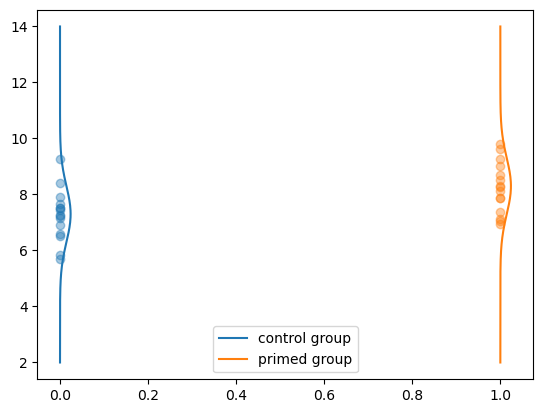

In [33]:
x = np.linspace(2,14,200)
y1 = stats.norm(7.3,1).pdf(x)
y1 = y1 / sum(y1)
y2 = stats.norm(8.3,1).pdf(x)
y2 = y2 / sum(y2)

plt.plot([0] * len(control_speed),control_speed,'o',color="tab:blue",alpha=0.6)
plt.plot([1] * len(primed_speed),primed_speed,'o',color="tab:orange",alpha=0.6)
plt.plot(y1,x,color="tab:blue",label="control group")
plt.plot(y2+1,x,color="tab:orange",label="primed group")
plt.legend()

Group 0 is the control group. Group 1 is the primed group. Each gets its own normal distribution with the same mean as we identified above. Now once we redraw the graph on the side, we can imagine a line running across the graph from the center of the blue dots to the center of the orange dots. This line can be described as a linear function. Let's have $a$ represent the mean of the blue group. Now the mean of the orange group is just a bit higher. We can express how much higher with $b$. Now the pick trick is that we can use the variable $x$ to designate which group you are in. The mean of any group is now given by:

$$y = a + b * x$$

When $x$ is 0, we are in the blue group. The $b$ parameter disappears because it's multiplied by zero. When $x$ is 1, the $b$ parameter turns on. We can get a more direct visualization of this function by using the widget below.

In [6]:
def draw_linear(a,b,s):
    x = np.array([0,1])
    plt.plot([0] * len(control_speed),control_speed,'o',color="tab:blue")
    plt.plot([1] * len(primed_speed),primed_speed,'o',color="tab:orange")
    
    l1 = stats.norm(a,s).logpdf(control_speed)
    l2 = stats.norm(a + b,s).logpdf(primed_speed)
    likelihood = np.sum(l1 + l2)

    print("log likelihood: " + str(likelihood))
    
    y = a + b*x
    plt.plot(x,y)
    
    x = np.linspace(2,14,300)
    
    y1 = stats.norm(y[0],s).pdf(x)
    y1 = y1 / sum(y1)
    y2 = stats.norm(y[1],s).pdf(x)
    y2 = y2 / sum(y2)
    
    plt.plot(y1,x,color="tab:blue",label="control group")
    plt.plot(y2+1,x,color="tab:orange",label="primed group")
    plt.show()
    
widgets.interact_manual(draw_linear, 
         a=widgets.FloatSlider(min=0, max=20, step=0.01, value=10),
         b=widgets.FloatSlider(min=-3, max=3, step=0.01, value=0),
         s=widgets.FloatSlider(min=0.001, max=5, step=.01, value=1));

interactive(children=(FloatSlider(value=10.0, description='a', max=20.0, step=0.01), FloatSlider(value=0.0, de…

If you adjust the sliders to find the line of best fit, you should find roughly:

- a = 7.3
- b = 1
- s = 1

This is equivalent to the answer we got estimating two independent normal distributions. 7.3 + 1 is 8.3, the mean of the second group in both cases. That's pretty neat! So if the later material gets confusing, just remember this linear function strategy is just a natural extension of what you already know, estimating two normals distributions.

## Normal distributions that slide

Why go through all this trouble of rewritting models as linear functions? There are two reasons. 

First, is it allows us combine causal effects from multiple sources. Suppose you thought there were two things that contribute to walking speed, $x_{1}$ and $x_{2}$. To make it more concrete, we can imagine $x_{1}$ is whether or not you are primed. $x_{2}$ can be whether or not you are sleepy. Now if you want to build a model where average walking speed decreases when you are primed and also decreases when you are sleepy, it is just:

$$y = a + b_{1} * x_{1} + b_{2} * x_{2}$$

We'll return to this additive effects strategy in a minute. The second advantage is that it naturally removes the restriction that we only estimate two groups. Now you can estimate any number of groups with the same model. Let's imagine $x$ can take on four possible values: 0, 1, 2, 3. If each additional value of x increases the value of y, then

$$y + a + b*x$$

can express this more complicated situation without changing the model at all. Let's look at what four groups looks like:

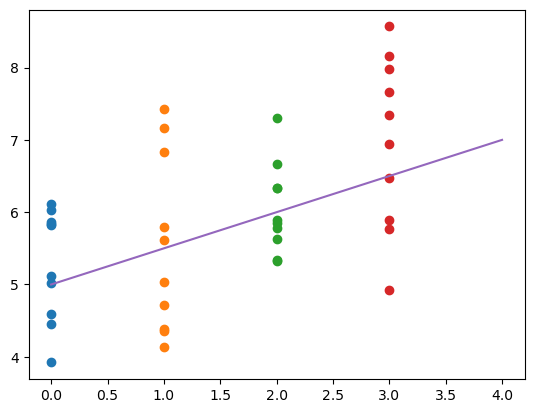

In [20]:
a = 5
b = 0.5
s = 1

x = np.array([0,1,2,3,4])
ys = a + b*x
for i in range(4):
    y_ob = stats.norm(y[i],s).rvs(10)
    plt.plot(np.repeat(x[i],10),y_ob,'o')

plt.plot(x,y)


If we can go from 2 groups to 4 groups, we can also go from 4 groups to any number of groups. You may have seen scatterplots with lines running through them before. These are typically called "regressions". Regressions are a generalization of the normal distribution model but $x$ can more around freely. So these are good if there is some cause that can take on a smooth range of values. For example, if each additional milligram of a psychiatric drug produces a similar change in some mental health outcome, then the range of values $x$ might take on starts at zero and might continue to 100 or whatever the upper limit on the safe dosage is.

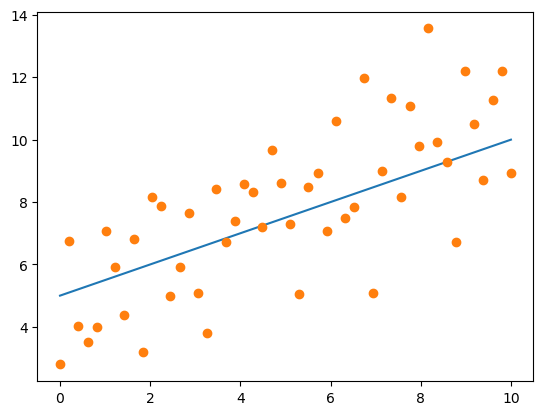

In [13]:
a = 5
b = 0.5
s = 2

x = np.linspace(0,10)
y = a + b*x
y_ob = stats.norm(y,s).rvs()

plt.plot(x,y)
plt.plot(x,y_ob,'o')

So what's going on in the background of these regression lines is that there is a series of normal distributions draw around the center of line and spreading out in both directions. Bayesian estimation attempts to explore which combination of $a$ and $b$ values gives the data high and low likelihoods. It can be helpful to visualize a kind of normal tunnel spreading out around the line. Data points close to the center are most likely. Data points far from the center are less likely. This visualization makes that a bit clearer. I've grabbed 10000 samples and plotted them transparently at each of 50 points along the line.

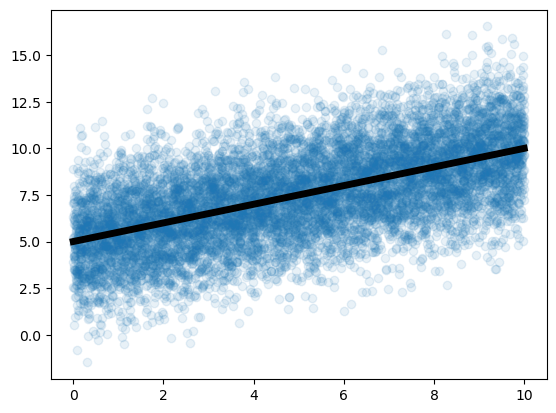

In [21]:
a = 5
b = 0.5
s = 2

x = np.linspace(0,10,10000)
y = a + b*x
y_ob = stats.norm(y,s).rvs()

plt.plot(x,y_ob,'o',alpha=0.1)
plt.plot(x,y,color="black",linewidth=5)

The practical upshot of all of this is that we can build more complex and flexible models by exploiting the same strategy we pursued with estimating two normal distributions. Instead of rewriting your pymc model 3 times to estimate three groups, you can write one pymc model that does the whole job at once.

I'll show you how to specify a pymc model that incorporates a linear function. The big change is how we specify priors. Before we tried to make our best guess for what the mean and standard deviation would be for either group and then set our priors there. Typically, we wanted to set our priors to be the same for both groups, which is a way of saying "I'm not sure whether the intervention will work". We can still do that but it's a bit indirect now because of the way we've rewritten the model. $a$ is the mean of the first group. $a + b$ is the mean of the second group. So there isn't a convenient way of specifying one prior for both groups. Instead of we do is put most of our prior information into $a$. Like if we are dealing with walking speeds, we know those have to be positive. So we can put a normal prior over $a$ with a mean in the positive numbers. Then the standard deviation of our prior expresses how uncertain we are about our predicted mean. Finally, we typically use a normal prior around $b$ with mean of zero. This expresses the idea that we don't have prior information about whether the treatment or experiment works in one direction or another. Priming might make people faster or slower. We don't know. That's why we are doing the experiment. So centering our $b$ prior around 0 expresses that.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


array([<AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 's'}>], dtype=object)

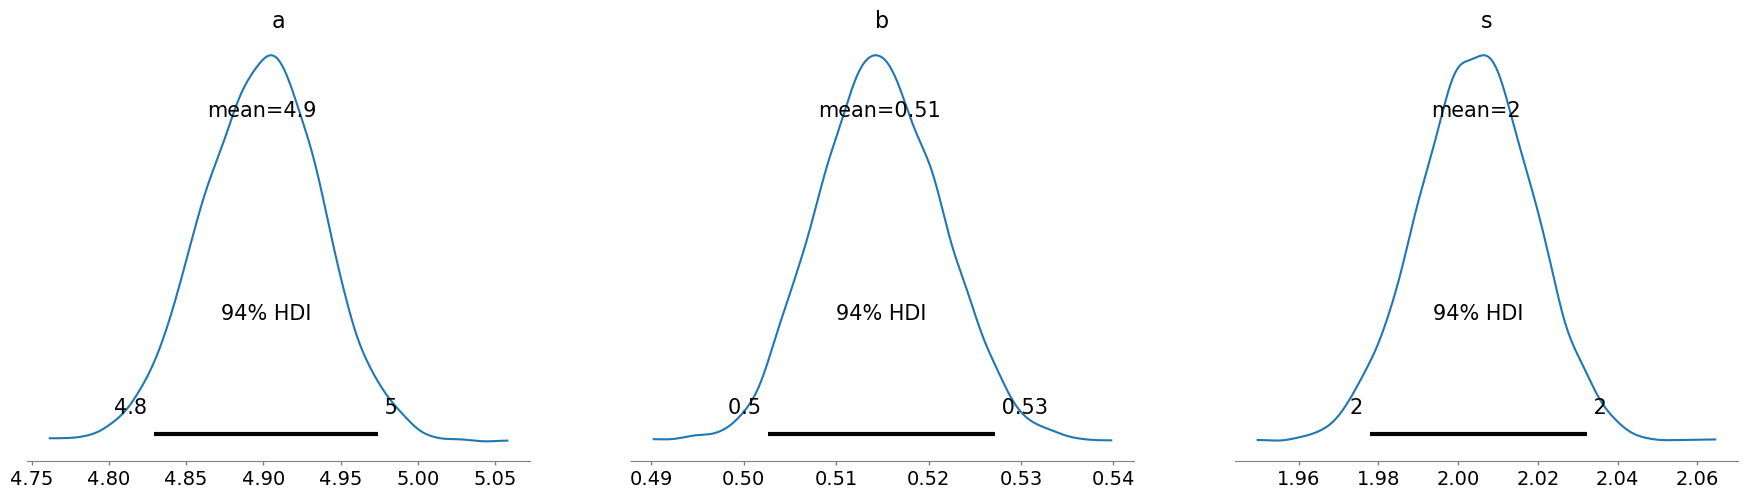

In [23]:
with pm.Model() as m0:
    a = pm.Normal('a',0,50) # i expect my intercept to be around 0 but 
                            # I'm pretty uncertain so I'll use a large standard deviation
    b = pm.Normal('b',0,50) # I expect my slope to be to around 0 but again uncertain
    s = pm.Exponential('s',1) # I expect my standard deviation to be around 1
    
    mean = a + b*x # the linear function part
    
    y = pm.Normal('y',mean,s,observed=y_ob) # the normal distribution moves around the with the linear function
    
    trace = pm.sample()
    
az.plot_posterior(trace)

# Causal graphs

Causal graphs are simple ways are saying what causes what. There are three ingredients to a causal graph:

- Nodes. These are the variables in the world. Whether or not you are primed, how fast you walk, how happy you are. Variables are numbers that go up and down. Nodes are represented by circles.
- Edges. These are the causal influences.
- Direction. Edges have arrows pointing in one (and only) direction. They tell you that some variable causes another but not the other way around. 

So to illustrate, this simple causal graph says priming causes walking speed. But walking speed cannot cause you to be primed. Why? Well, the experimenter decides who gets to be primed or not.

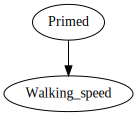

In [30]:
dot = Digraph() # set up the graph object

dot.node("a",'Primed') # a node to the graph object. Called 'a' but labeled 'primed'
dot.node("b",'Walking_speed') # add a second note. Same syntax as above.

dot.edges(['ab']) # add an edge from a to be
dot # display the graph

We can design simulations that follow the logic of causal graphs. Any time there is an arrow, that means the variable being pointed at is a linear function of the all the nodes doing the point. So walking speed is a linear function or priming.

To construct a simulation for a causal graph, randomly generate values for all nodes that have no arrows point into them. In our case, priming independent and free of arrows pointing at it. Take all the nodes where arrows point into them and make them linear functions. For example:

In [28]:
# simulate priming data

primed = np.random.randint(low=0,high=2,size=30)
primed

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0])

In [29]:
# linear expression

walking_speed = 8 - 1 * primed
walking_speed

array([7, 7, 8, 8, 7, 8, 7, 8, 7, 7, 8, 8, 7, 7, 7, 8, 7, 7, 8, 7, 7, 7,
       8, 8, 7, 7, 7, 8, 8, 8])

## Adding noise to a graph

Just as important as what *is* depicted on a causal graph is what is *not* depicted. Implicitly, the causal graph we drew above says that nothing else can cause changes in walking speed. But that is silly. As we have righly noted for a while now, a bunch of other things can cause variation in walking speed. Let's draw some.

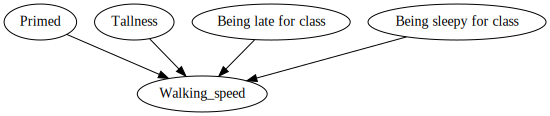

In [8]:
dot = Digraph()

dot.node("a",'Primed') # generate a node "a", label it "primed" and add it to the graph named dot
dot.node("b",'Walking_speed')
dot.node("n","Tallness")
dot.node("k","Being late for class")
dot.node("j","Being sleepy for class")

dot.edges(['ab']) # connect a to b
dot.edges(['nb']) # connect n to b
dot.edges(['kb'])
dot.edges(['jb'])
dot

And build the corresponding simulation. We'll imagine that priming decreases the time you spend in the hallway, tallness decreases it too (tall people walk faster), being late for class does to, but being sleepy increases the time you spend in the hallway.

In [9]:
# generate random values for all independent nodes

primed = np.random.randint(low=0,high=2,size=30)
tallness = stats.norm(170,10).rvs(30)
late = np.random.randint(low=0,high=2,size=30)
sleepy = np.random.randint(low=0,high=2,size=30)

# linear expression

walking_speed = 8 - 1 * primed - 0.01 * tallness - 0.5 * late + 0.4 * sleepy

# display

walking_speed

array([6.2797949 , 4.7382172 , 6.86736848, 5.69645785, 6.47001634,
       5.42732892, 5.67022199, 5.14445931, 6.32125123, 5.28493111,
       4.7967476 , 5.16990415, 6.18110858, 5.85679837, 6.72350619,
       5.73141761, 5.80239932, 6.09142571, 6.30113368, 6.32216258,
       5.3571728 , 5.17959336, 5.31907085, 5.05942891, 5.37693959,
       4.7809381 , 4.69035593, 6.07626953, 6.81905274, 5.19452177])

We are finally ready for our first big insight to take away from all this causal graph stuff. One big theme over the last couple classes is that there are two kinds of variation. Random and non-random variation. Random variation does not typically hurt our ability to make scientific inferences. We have standard statistical tools for peeling apart the random variation from the real causal effect we are hoping to measure. I've been encouraging you to think that it's really non-random variation that is the source of bias in experiments.

But that is somewhat hard to believe. If there is a lot of random variation, surely that should mean that it is hard to tell what the causal effect is. How the hell can statistical tools actually pull off that "peeling" apart trick unless we know and have measured the other causal factors. In practice we don't measure all the other stuff, we group all the other factors together as just "noise" and they flow into our standard deviation term.

I want to build a demonstrate that show this is okay. You can still figure out be the effect of priming is on walking speed without having any idea which participants are sleepy and which are late for class. Let's apply a pymc model to our simulated data. We are only going to feed the pymc model measurements about walking speed and priming. The rest it just has to figure out for itself.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Priming, Noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'Priming'}>,
       <AxesSubplot: title={'center': 'Noise'}>], dtype=object)

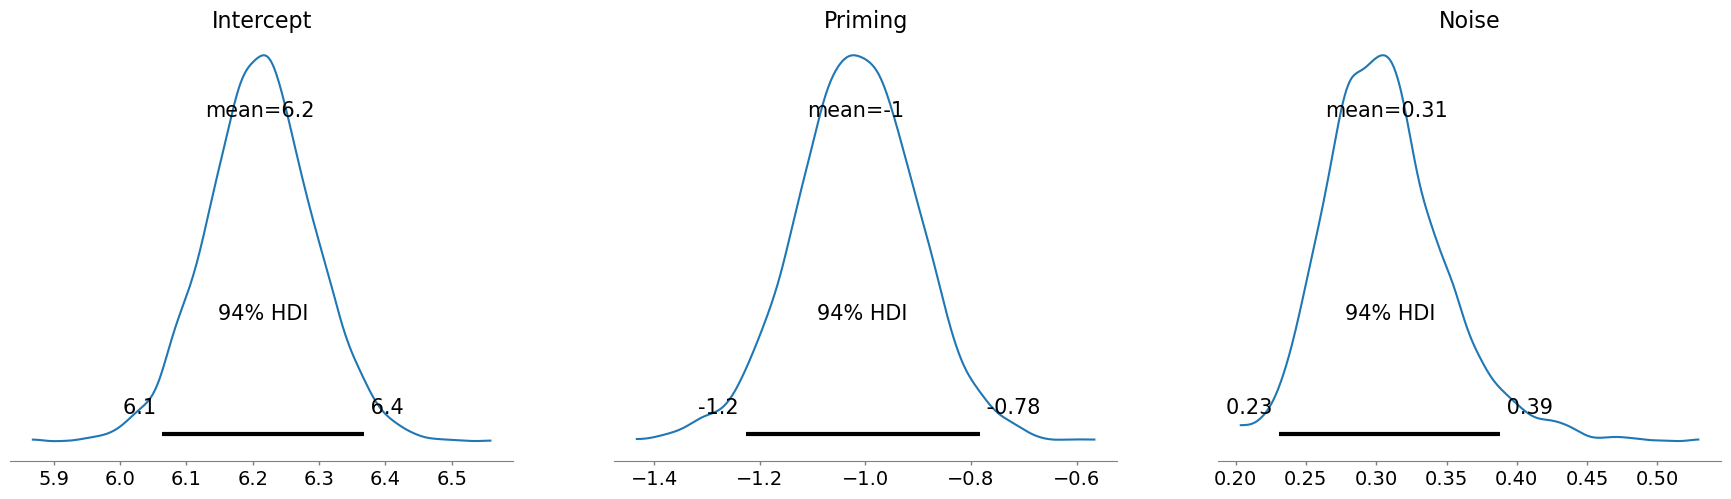

In [33]:
with pm.Model() as m1:
    a = pm.Normal('Intercept',10,5)
    b = pm.Normal('Priming',0,10)
    s = pm.Exponential('Noise',1)
    
    mean = a + b*primed
    
    y = pm.Normal('y',mean,s,observed=walking_speed)
    
    trace = pm.sample()
    
az.plot_posterior(trace)

Remarkably, it estimates the priming effect to be -1. If you look back to the simulation, that is exactly what we programmed into the linear function. So the model learns the correct answer to the question: "how much does priming change the walking speed" even without knowing about all the other features that contribute to it.

We can show this is equivalent to another graph that simply groups all the other factors together under the label "noise".

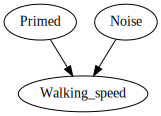

In [36]:
dot = Digraph()

dot.node("a",'Primed')
dot.node("b",'Walking_speed')
dot.node("n","Noise")

dot.edges(['ab'])
dot.edges(['nb'])
dot

Any time we want to add noise to our data, we can just grab samples from a random variable.

In [34]:
# simulate priming data

primed = np.random.randint(low=0,high=2,size=30)
noise = stats.norm(0,0.3).rvs(30)

# linear expression

walking_speed = 8 - 1 * primed + noise

# display

walking_speed

array([7.93935242, 6.82020714, 7.03840667, 7.43742984, 6.65639176,
       7.2213144 , 8.08818074, 7.89251559, 6.63968537, 7.72316012,
       7.19290932, 7.71670845, 6.52199885, 8.19063823, 7.15765574,
       7.79220766, 6.96179766, 7.04418059, 6.93070737, 6.74670985,
       7.93078687, 8.13137371, 8.05657956, 7.74125681, 7.10400784,
       7.07569643, 7.75923185, 8.7025689 , 7.57017891, 7.03996763])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Priming, Noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'Priming'}>,
       <AxesSubplot: title={'center': 'Noise'}>], dtype=object)

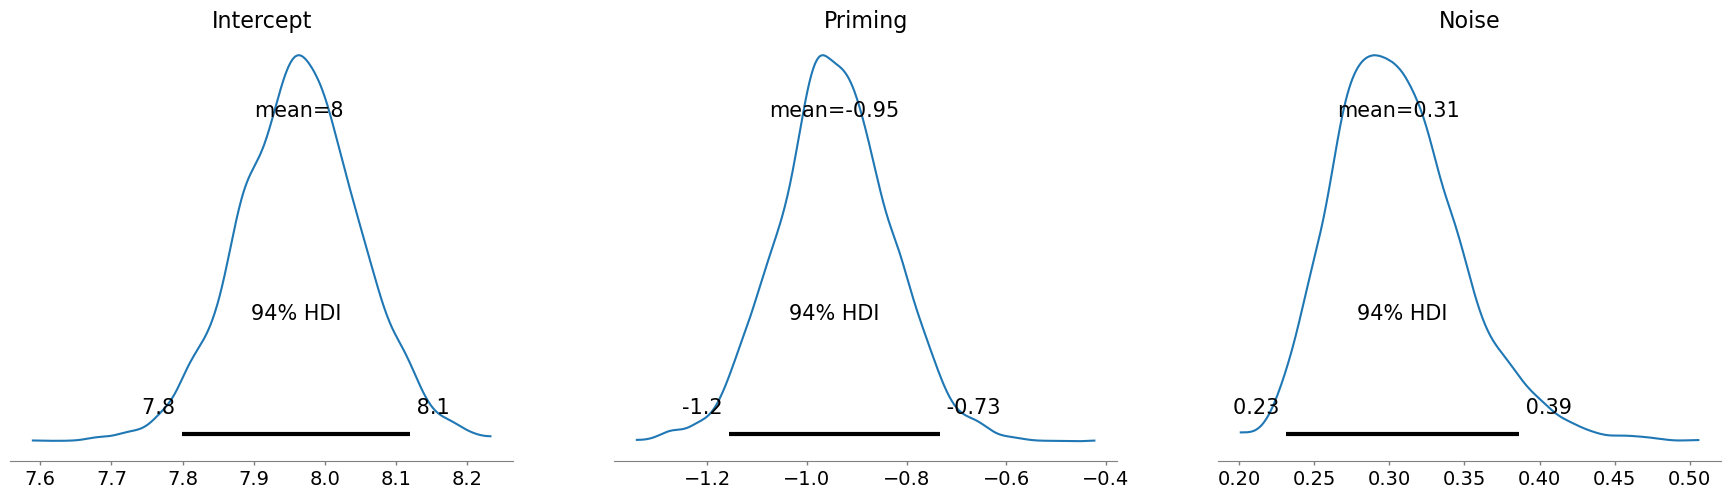

In [35]:
with pm.Model() as m2:
    a = pm.Normal('Intercept',10,5)
    b = pm.Normal('Priming',0,10)
    s = pm.Exponential('Noise',1)
    
    mean = a + b*primed
    
    y = pm.Normal('y',mean,s,observed=walking_speed)
    
    trace = pm.sample()
    
az.plot_posterior(trace)

Again it learns the correct answer. This time the estimate is -0.95, but close enough. 

How is our statistical model doing this? Two ingredients: the mechanics of normal distribution + bayesian esimation. Remember what a normal distribution really is from our generative simulations a couple classes back: there is some base line value for a variable. Then there are factors that add a little and subtract a litte. If you repeatedly add and substract a little from some baseline, you get a normal distribution. Factors like lateness, sleepiness and tallness are just different factors that add and subtract a little.

Bayesian estimation explores different combinations of parameters to identify which ones provide the best explanation of the data. So as we explore different value for the priming effect, it gives us clues about how much noise must be left over. As we learn more about how much noise is in the data, it gives us clues about how big the priming effect must be. By wiggling both values repeatedly, we can zoom in on the best mixture of noise and causal effect.

# Adding mediators

Noise is one type of common causal graph. Another one is mediation. We've seen mediation before a couple classes ago. But to recap, the graph looks like this:

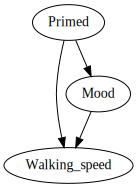

In [37]:
dot = Digraph()

dot.node("a",'Primed')
dot.node("b",'Walking_speed')
dot.node("c","Mood")

dot.edges(['ac'])
dot.edges(['ab'])
dot.edges(['cb'])
dot

To develop a simulation that matches this causal graph, we use the same procedure:

- randomly generate values for primed.
- make mood a linear function of primed.
- make walking speed a linear function of both mood and primed.

In [56]:
primed = np.random.randint(low=0,high=2,size=30)
mood = 0 - 3 * primed
walking_speed = 8 - 1 * primed - 0.5 * mood
walking_speed

array([8. , 8. , 8.5, 8. , 8.5, 8.5, 8.5, 8.5, 8. , 8.5, 8.5, 8. , 8.5,
       8. , 8.5, 8.5, 8. , 8.5, 8. , 8. , 8. , 8. , 8. , 8.5, 8.5, 8.5,
       8.5, 8. , 8.5, 8.5])

This graph, again is unrealistic. We are missing noise factors. Now we have two kinds: noise of mood and noise on walking speed. You would think that mood is caused by more factors that just priming. So we'll draw a noise arrow into it as well.

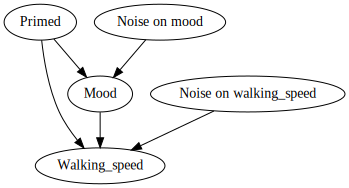

In [38]:
dot = Digraph()

dot.node("a",'Primed')
dot.node("b",'Walking_speed')
dot.node("c","Mood")
dot.node("n","Noise on mood")
dot.node("u","Noise on walking_speed")

dot.edges(['ac'])
dot.edges(['ab'])
dot.edges(['cb'])
dot.edges(['nc'])
dot.edges(['ub'])
dot

We end up up with a fairly involved causal graph. Here is how we can generate a simulation from this graph:

In [53]:
# generate all variables that are not a function of anything

sample_size = 400

primed = np.random.randint(low=0,high=2,size=sample_size) # random assignment to priming condition
noise_on_mood = stats.norm(0,2).rvs(sample_size) # noise
noise_on_walking_speed = stats.norm(0,1).rvs(sample_size) # noise

# mood = baseline mood + priming effect + noise

mood = 0 - 3 * primed + noise_on_mood

# walking speed = baseline + priming effect + mood effect + noise

walking_speed = 8 - 1 * primed + 0.5 * mood + noise_on_walking_speed

In this simulation, I've made up the numbers. That's okay because the point is to illustrate a general principle: if I can construct an artifical world and my statistical machine can learn the important facts about this statistical world, then I can trust that the method works. If the real world was like my made up world, then I know this is the right statistical model to apply. In this case, I have two causal parameters, the priming effect is -1. The mood effect is 0.5. So let's see if our statistical machine can learn the right answers.

Okay now the big question for us: suppose we want to know the *direct* effect of priming on walking speed, which variables do you need to have measurements on? A direct effect is the pathway that leads from priming to walking speed, without traveling down any side routes, like mood. 

In the last example, exploring noise, we learned we need to measure far fewer variables than you might expect. In this example, we have to measure both mood and priming to get the correct estimate. This pymc model illustrates. Notice, also, that we can exploit our additive linear model strategy here. Walking speed is just the sum of two effects.

In [54]:
with pm.Model() as mediation:
    a = pm.Normal('Intercept',10,5)
    b1 = pm.Normal('Priming',0,10)
    b2 = pm.Normal('Mood',0,10)
    s = pm.Exponential('Noise',1)
    
    mean = a + b1*primed + b2*mood
    
    y = pm.Normal('y',mean,s,observed=walking_speed)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Priming, Mood, Noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'Priming'}>,
       <AxesSubplot: title={'center': 'Mood'}>,
       <AxesSubplot: title={'center': 'Noise'}>], dtype=object)

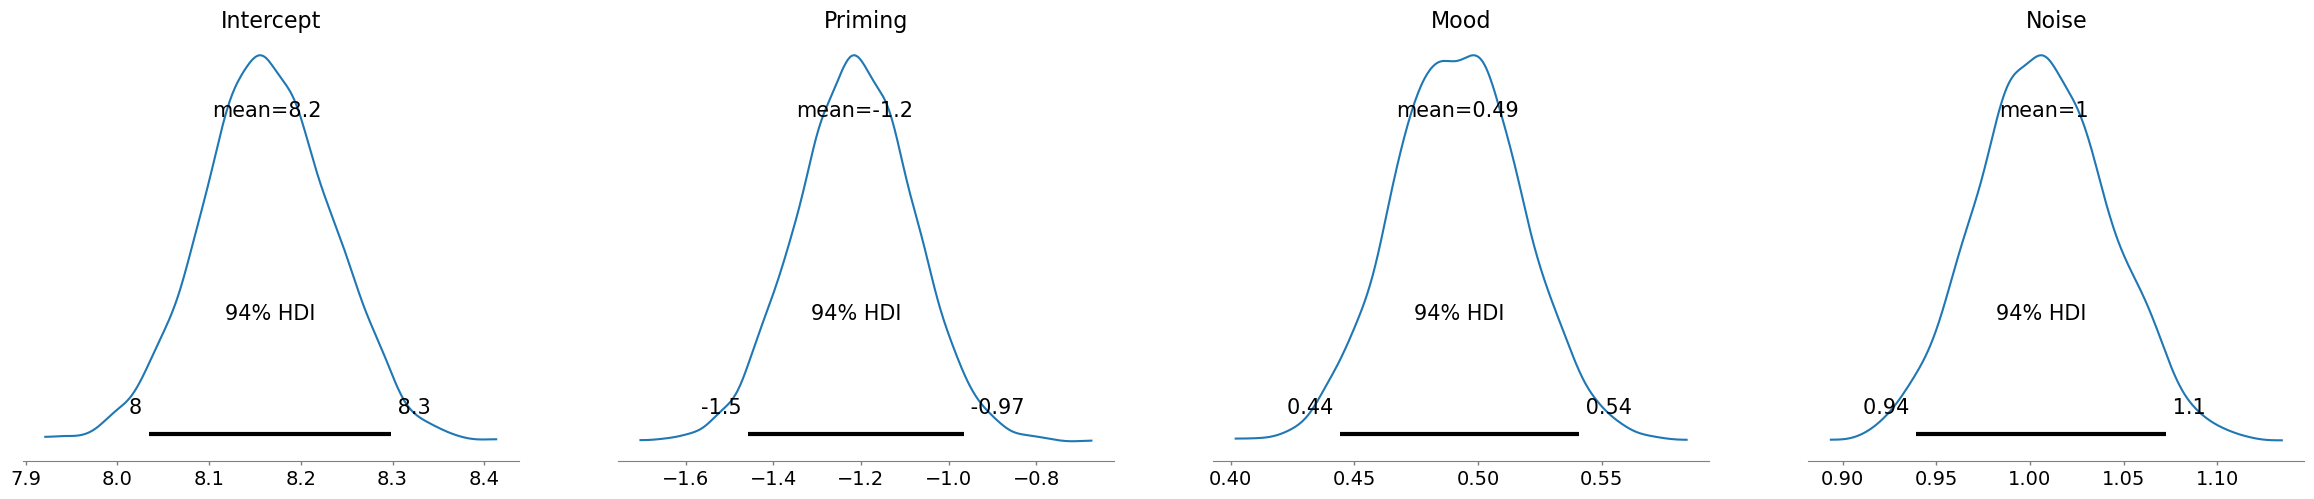

In [55]:
az.plot_posterior(trace);

We can see that it the model does a fairly good job. It thinks the priming effect is about -1.2. In reality, it is -1. So not so far off. Our model also thinks the mood effect is -0.49. The real mood effect is 0.5. So again really good. We know the real effect sizes because we programmed them into the simulations we built. Simulations serve as a technical for validating that our statistical machines are working as intended.

You might notice that I've cranked up the sample size for this simulation to 400. As causal networks become more complicated, you typically need a corresponding increase in the sample sample size to reliably estimate each component of the model. So you can play around with the sample sizes here to get a sense for what sample size is appropriate for a model of given complexity.

# Direct effect vs total effect

In the last example, we explored the *direct* effect of priming on speed. That is, how causal influence goes directly from priming to speed, without travelling down any side routes. However, there is a different kind of causal estimate we might want, the *total* effect. The total effect includes every possible path from priming to mood. You estimate the total effect by just omitting every mediating variable. 

To illustrate, we'll use the same simulation.

In [56]:
# generate all variables that are not a function of anything

sample_size = 400

primed = np.random.randint(low=0,high=2,size=sample_size) # random assignment to priming condition
noise_on_mood = stats.norm(0,2).rvs(sample_size) # noise
noise_on_walking_speed = stats.norm(0,1).rvs(sample_size) # noise

# mood = baseline mood + priming effect + noise

mood = 0 - 3 * primed + noise_on_mood

# walking speed = baseline + priming effect + mood effect + noise

walking_speed = 8 - 1 * primed + 0.5 * mood + noise_on_walking_speed

But this time, we'll omit the mood variable in the pymc model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Priming, Noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


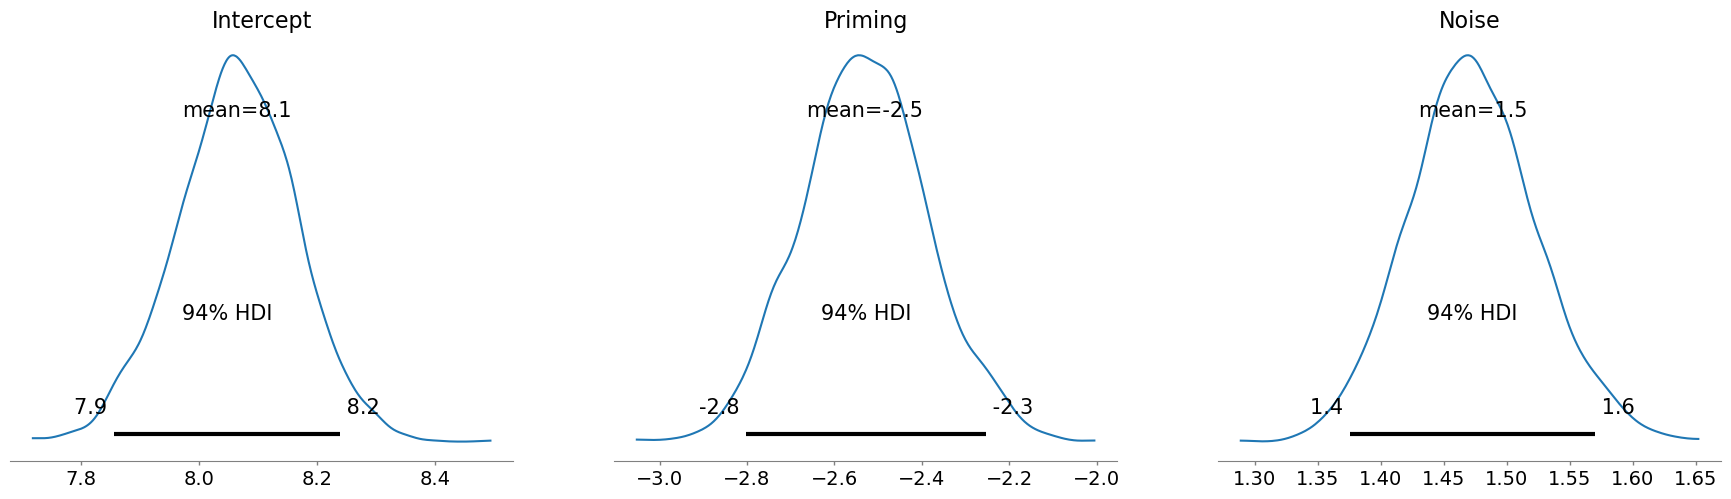

In [57]:
with pm.Model() as mediation:
    a = pm.Normal('Intercept',10,5)
    b1 = pm.Normal('Priming',0,10)
    s = pm.Exponential('Noise',1)
    
    mean = a + b1*primed
    
    y = pm.Normal('y',mean,s,observed=walking_speed)
    
    trace = pm.sample()
    
az.plot_posterior(trace);

The resulting estimate is -2.5 for the priming effect. So the total effect is much larger than the direct effect. 

Why -2.5? Well -2.5 is the sum of two different causal pathways. The first causal pathway is the direct one, just -1. The second causal pathway is more complicated. But notice that priming causes a -3 effect on mood. And then mood causes a 0.5 effect on speed. And -3 * 0.5 = -1.5. The really neat part is that -1 (direct path) + -1.5 (indirect path) is -2.5 (total effect). So the causal graphs have this amazing property where the total effect is just the sum of each distinct causal pathway.

# Some concluding themes

Today has mostly just been about introducing the mathematical devices for thinking about causal effects. Next class we'll get back to the philosophy. But to recap, we learned three neat facts about causal graphs.

- If you have more than one unmeasured noise node, you can regroup all of them into a single noise node and include only one general standard deviation term in your model. This goes some way to explaining why models are able to detect causal effects even when there is a lot of noise. It doesn't matter how many different sources of noise you have.

Random variation is well handled by our tools. But when there are nodes that connected to both our primary cause of interest and the outcome of interest, then we need to be more careful. In the case of mediators we have two rules: 

- If you want to learn the direct effect of a node, you need to measure and include all mediating pathways into your statistical model.

- If you want to learn the total effect of a node, you should not include all mediating pathways into your statistical model.
